In [401]:
import numpy as np
import pandas as pd
import math
import requests
import sqlite3
import json

import re

import matplotlib.pyplot as plt

# Collect weather infor through visualCrossing API
## Figure out the unique cities where weather data are required

In [179]:
def get_info(input_db):
    conn = sqlite3.connect(input_db)
    df = pd.read_sql_query("SELECT id, name, lat, lng, address FROM info", conn)
    conn.close()
    return df

In [180]:
philly_parks = get_info(input_db='philly_parks_info.db')

philly_parks.head()

,id,name,lat,lng,address
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,38.937670,-76.500899,"600 Quiet Waters Park Rd, Annapolis, MD 21403,..."
1,ChIJzcow6Xb1t4kRQVE7s1AWWr8,Hillsmere Shores Community Beach,38.927212,-76.494150,"101 W Bay View Dr, Annapolis, MD 21403, USA"
2,ChIJ_bk5K1z1t4kRQNverIUOVko,Quiet Waters Dog Beach,38.930202,-76.508341,"1701-1799 Quiet Waters Park Rd, Annapolis, MD ..."
3,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,Quiet Waters Dog Park,38.931865,-76.505658,"600 Quiet Waters Park Rd, Annapolis, MD 21403,..."
4,ChIJQWcsgIn2t4kRCL0Ub363FyI,Pip Moyer Recreation Center (Annapolis Recreat...,38.963271,-76.505150,"273 Hilltop Ln, Annapolis, MD 21403, USA"


In [293]:
def find_city_level_address(address):
    if isinstance(address, str): 
        address_regex = r'(^|,)?\s*([A-Za-z ]+, [A-Z]{2})\s*\d*, (USA|United States)'
        city_find = re.search(address_regex, address)
        if city_find is not None:
            return city_find.group(2).replace(", ", ",")
        else: 
            print('Cannot find city-level address: ' + address)
    

In [464]:
city_address = philly_parks['address'].apply(find_city_level_address)

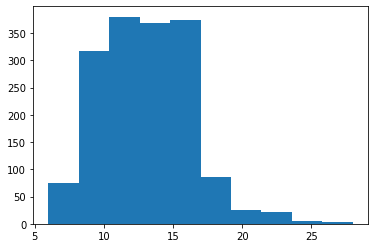

In [99]:
plt.hist(city_address.str.len()); 

In [102]:
city_address[city_address.str.len()>25]

645      Upper Frederick Township,PA
646      Upper Frederick Township,PA
1287    West Collingswood Heights,NJ
Name: address, dtype: object

In [86]:
philly_parks.loc[301]

id                    ChIJ76ZSUfJGxokR87GRHyx1S14
name            Salisbury Township Community Park
lat                                       39.9949
lng                                      -76.0192
address    750 White Horse Rd, Gap, PA 17527, USA
Name: 301, dtype: object

In [122]:
len(city_address.unique())

386

In [181]:
pa_state_parks = get_info(input_db='philly_state_parks_info.db')

In [130]:
pa_state_city_address = pa_state_parks['address'].apply(find_city_level_address)

Cannot find city-level address: Rothrock State Forest, Pennsylvania 16669, USA


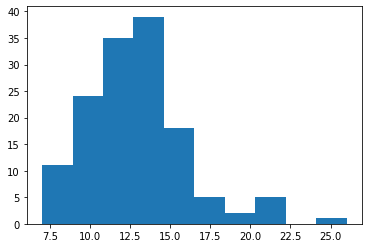

In [128]:
plt.hist(pa_state_city_address.str.len()); 

In [135]:
len(pa_state_city_address[~pa_state_city_address.isnull()].unique())

118

In [182]:
nyc_parks = get_info(input_db='nyc_parks_info.db')
nyc_parks.head()

,id,name,lat,lng,address
0,ChIJDbzqHhXFw4kR5dCbhMQVy7Q,Dideriksen Park,40.402741,-74.430946,"Fern Rd, East Brunswick, NJ 08816, USA"
1,ChIJO5COJz3Fw4kRQxVRafcYWpw,East Brunswick Dog Park,40.400022,-74.440014,"Dunhams Corner Rd, East Brunswick, NJ 08816, USA"
2,ChIJM29CK8PFw4kRWZIbxcestzo,Gloria Bradford Borough Park,40.450825,-74.432411,"80 Violet Terrace, Milltown, NJ 08850, USA"
3,ChIJnQ9L1fPFw4kRZ7FelqVzLP4,Country Lane Park,40.443431,-74.414823,"20 Wedgewood Ct, East Brunswick, NJ 08816, USA"
4,ChIJKw0kXxHGw4kRn0bEGob21as,Rutgers Gardens,40.473419,-74.422737,"112 Log Cabin Rd, North Brunswick Township, NJ..."


In [123]:
nyc_city_address = nyc_parks['address'].apply(find_city_level_address)

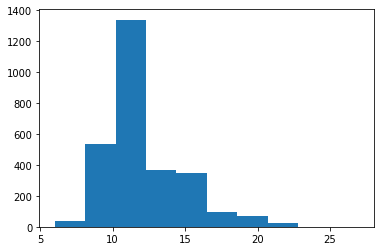

In [110]:
plt.hist(nyc_city_address.str.len());

In [124]:
len(nyc_city_address.unique())

425

### Merge of three info tables

In [283]:
parks_info = pd.concat((philly_parks, philly_state_parks, nyc_parks), axis=0)
parks_info.head()

,id,name,lat,lng,address
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,38.937670,-76.500899,"600 Quiet Waters Park Rd, Annapolis, MD 21403,..."
1,ChIJzcow6Xb1t4kRQVE7s1AWWr8,Hillsmere Shores Community Beach,38.927212,-76.494150,"101 W Bay View Dr, Annapolis, MD 21403, USA"
2,ChIJ_bk5K1z1t4kRQNverIUOVko,Quiet Waters Dog Beach,38.930202,-76.508341,"1701-1799 Quiet Waters Park Rd, Annapolis, MD ..."
3,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,Quiet Waters Dog Park,38.931865,-76.505658,"600 Quiet Waters Park Rd, Annapolis, MD 21403,..."
4,ChIJQWcsgIn2t4kRCL0Ub363FyI,Pip Moyer Recreation Center (Annapolis Recreat...,38.963271,-76.505150,"273 Hilltop Ln, Annapolis, MD 21403, USA"


In [237]:
parks_info.shape

(4614, 5)

In [240]:
len(parks_info['id'].unique())

4601

In [206]:
from collections import defaultdict
parks_id = defaultdict(int)
for id in parks_info['id']:
    parks_id[id] += 1

_ = [(k,v) for k,v in parks_id.items() if v>1] # all duplicates are due to state parks/forests already in philly_list

In [205]:
parks_info[parks_info['id']=='ChIJdfywo6xXwYkRuS111bIPKqU']

,id,name,lat,lng,address
1528,ChIJdfywo6xXwYkRuS111bIPKqU,Washington Crossing Historic Park,40.294931,-74.872113,"1112 River Rd, Washington Crossing, PA 18977, USA"
1771,ChIJdfywo6xXwYkRuS111bIPKqU,Washington Crossing Historic Park,40.294931,-74.872113,"1112 River Rd, Washington Crossing, PA 18977, ..."


In [284]:
parks_info.drop_duplicates(subset='id', inplace=True, ignore_index=True)

In [285]:
parks_info[parks_info['address'].isna()]

,id,name,lat,lng,address


In [286]:
parks_info.shape

(4601, 5)

## Identify parks with curr_popularity measurements

In [258]:
def load_curr_popularity(input_db):
    conn = sqlite3.connect(input_db)
    df = pd.read_sql_query("SELECT id, request_id, rating_n, timestamp, curr_popularity FROM curr_popularity  WHERE curr_popularity >= 0", conn)
    conn.close()
    return df

In [259]:
philly_curr_pop = load_curr_popularity(input_db='data/philly_outdoor_popularity_half_hour_0408_0409.db')

In [170]:
philly_curr_pop.shape

(9062, 5)

In [278]:
def park_with_curr_popularity(curr_df, id_type='id'):
    # find the unique place id with 'curr_popularity'
    place_with_currpop = curr_df[curr_df['curr_popularity']>=0]['id'].unique()
    print('# of parks with curr_popularity ' + str(place_with_currpop.shape[0]))
    return place_with_currpop

In [279]:
philly_with_currpop = park_with_curr_popularity(curr_df=philly_curr_pop, id_type='request_id') 

# of parks with curr_popularity 308


In [176]:
type(philly_with_currpop)

numpy.ndarray

In [280]:
nyc_curr_pop = load_curr_popularity(input_db='data/nyc_outdoor_popularity_half_hour_0404_0405.db')
print(nyc_curr_pop.shape)
nyc_with_currpop = park_with_curr_popularity(curr_df=nyc_curr_pop, id_type='request_id') 

(21296, 5)
# of parks with curr_popularity 682


In [281]:
park_id_with_curr_pop = list(philly_with_currpop) + list(nyc_with_currpop)
len(set(park_id_with_curr_pop))

990

### Find city-level address of parks with curr_popularity

In [287]:
parks_info = parks_info.set_index('id')

In [288]:
parks_info_filtered = parks_info.reindex(index = park_id_with_curr_pop)

In [289]:
# parks_info_filtered = parks_info_filtered.reset_index()
parks_info_filtered.head()

,name,lat,lng,address
id,,,,
ChIJca02AuScyIkREH1pXTDGeIE,Columbia River Park,40.030948,-76.508786,"Columbia, PA 17512, USA"
ChIJOwA0J6YCuIkRaK-0pk4S95E,Broadneck Park,39.034094,-76.452529,"613 College Pkwy, Annapolis, MD 21409, USA"
ChIJBf9gK23kx4kR7d1LnPPvyp8,Mariner Point Park,39.400009,-76.349981,"100 Kearney Dr, Joppatowne, MD 21085, USA"
ChIJ34HlWAA7xokRlJXhz26rb-g,Greenfield Park,40.053394,-76.245834,"3105172000000, Lancaster, PA 17601, USA"
ChIJ2R92Tl7Gx4kRO6G7NcWtNhk,Susquehanna State Park,39.604816,-76.151670,"4188 Wilkinson Rd, Havre De Grace, MD 21078, USA"


In [294]:
parks_city_address = parks_info_filtered['address'].apply(find_city_level_address)

In [298]:
parks_city_address_unique = parks_city_address[~parks_city_address.isnull()].unique()
len(parks_city_address_unique)

382

In [350]:
parks_city_address_unique[:5]

array(['Columbia,PA', 'Annapolis,MD', 'Joppatowne,MD', 'Lancaster,PA',
       'Havre De Grace,MD'], dtype=object)

## Query historical weather data for these cities using visualcrossing API

In [301]:
# online example - 
# https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Springfield,IL/2021-03-11/2021-04-10?unitGroup=us&key=AHBS12DVFHFFSHF764DGDB
# see doc: 
# https://www.visualcrossing.com/resources/documentation/weather-api/timeline-weather-api/ 
with open('weather_data/testing/response.json') as f:
    exp_weather = json.load(f)

In [303]:
exp_weather.keys()

dict_keys(['queryCost', 'latitude', 'longitude', 'resolvedAddress', 'address', 'timezone', 'tzoffset', 'description', 'days', 'alerts', 'stations', 'currentConditions'])

In [308]:
len(exp_weather['days'])

31

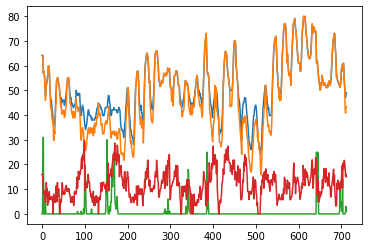

In [349]:
# len(exp_weather['days'][0]['hours']) #for each hour (24 in total)
# [exp_weather['days'][i]['datetime'] for i in range(31)] #all the dates requested

plt.plot([exp_weather['days'][iday]['hours'][ihour]['temp'] for iday in range(31) for ihour in range(23)] )
plt.plot([exp_weather['days'][iday]['hours'][ihour]['feelslike'] for iday in range(31) for ihour in range(23)] )

plt.plot([(exp_weather['days'][iday]['hours'][ihour]['precip'] or 0) * 100 for iday in range(31) for ihour in range(23)] )
plt.plot([exp_weather['days'][iday]['hours'][ihour]['windspeed'] for iday in range(31) for ihour in range(23)] )


In [351]:
exp_weather['days'][1].keys()

dict_keys(['datetime', 'datetimeEpoch', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'sunrise', 'sunriseEpoch', 'sunset', 'sunsetEpoch', 'moonphase', 'conditions', 'description', 'icon', 'stations', 'source', 'hours'])

In [353]:
exp_weather['days'][1]['sunrise']

'06:14:14'

In [335]:
exp_weather['days'][1]['hours'][3].keys()

dict_keys(['datetime', 'datetimeEpoch', 'temp', 'feelslike', 'humidity', 'dew', 'precip', 'precipprob', 'snow', 'snowdepth', 'preciptype', 'windgust', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'icon', 'stations', 'source'])

In [373]:
exp_weather['days'][1]['hours'][3]['datetime']

'03:00:00'

In [ ]:
# called with history endpoint
with open('weather_data/testing/response_0407_08.json') as f:
    la_pa = json.load(f)


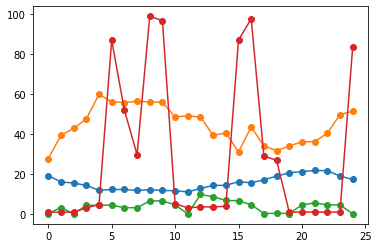

In [376]:
plt.plot([la_pa['locations']['Lancaster,PA,US']['values'][i]['temp'] for i in 
 range(len(la_pa['locations']['Lancaster,PA,US']['values']))], '-o')
plt.plot([la_pa['locations']['Lancaster,PA,US']['values'][i]['humidity'] for i in 
 range(len(la_pa['locations']['Lancaster,PA,US']['values']))], '-o')
plt.plot([la_pa['locations']['Lancaster,PA,US']['values'][i]['wspd'] for i in 
 range(len(la_pa['locations']['Lancaster,PA,US']['values']))], '-o')

plt.plot([la_pa['locations']['Lancaster,PA,US']['values'][i]['cloudcover'] for i in 
 range(len(la_pa['locations']['Lancaster,PA,US']['values']))], '-o')

In [377]:
# called  with timeline
with open('weather_data/testing/response_philly_0407_08.json') as f:
    philly_weather = json.load(f)

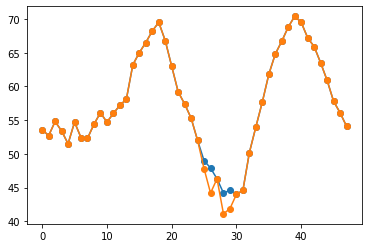

In [387]:
plt.plot([philly_weather['days'][iday]['hours'][ihour]['temp'] for iday in range(2) for ihour in range(24)], '-o')
plt.plot([philly_weather['days'][iday]['hours'][ihour]['feelslike'] for iday in range(2) for ihour in range(24)], '-o')


In [388]:
philly_weather['days'][0].keys()

dict_keys(['datetime', 'datetimeEpoch', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'sunrise', 'sunriseEpoch', 'sunset', 'sunsetEpoch', 'moonphase', 'conditions', 'description', 'icon', 'stations', 'source', 'hours'])

In [385]:
philly_weather['days'][0]['hours'][8].keys()

dict_keys(['datetime', 'datetimeEpoch', 'temp', 'feelslike', 'humidity', 'dew', 'precip', 'precipprob', 'snow', 'snowdepth', 'preciptype', 'windgust', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'icon', 'stations', 'source'])

In [397]:
philly_weather.keys()

dict_keys(['queryCost', 'latitude', 'longitude', 'resolvedAddress', 'address', 'timezone', 'tzoffset', 'days', 'stations'])

In [392]:
from visualcrossing_config import key

In [395]:
from urlib.parse import quote

def format_url(location, date1, date2):
    url = quote('https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{}/{}/{}?unitGroup=us&key={}'.format(location, date1, date2, key))
    return url

In [418]:
def generate_filename(loc, start_date, end_date):
    return re.sub("[ ,]", "_", loc + '_Date_' + start_date + '_' + end_date + '.json')

generate_filename(location, start_date, end_date)

'Annapolis_MD_Date_2021-04-07_2021-04-07.json'

In [421]:
def write_result_to_json(result, location, start_date, end_date):
    with open('weather_data/' + generate_filename(location, start_date, end_date), 'w+') as f:
        json.dump(result.json(), f)

In [461]:
import time
from ediblepickle import checkpoint
from retrying import retry

import os

cache_dir = 'weather_data_cache'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir) 

def generate_cache_filename(loc, start_date, end_date):
    fname = generate_filename(loc, start_date, end_date)
    prefix, ext = os.path.splitext(fname)
    
    # strip .json and replace with .p
    return prefix + '.p'
    
@checkpoint(key=lambda args, kwargs: generate_cache_filename(*args), work_dir=cache_dir)
def get_link_result(location, start_date, end_date):
    print(f"Fetching weather data for {location} @ {start_date} -> {end_date}")
    
    url = format_url(location, start_date, end_date)
    result = requests.get(url)
    time.sleep(.2)
    
    if result.status_code != 200:
        print(f"Request to {location} failed with: {result.text}")
        raise RuntimeError("Request failed")
    else:    
        write_result_to_json(result, location, start_date, end_date)
        
    return result

In [399]:
!pip install ediblepickle

  Created wheel for ediblepickle: filename=ediblepickle-1.1.3-py3-none-any.whl size=7548 sha256=0923fe0f7ba50cdf9f981ef5763c9240486403301b62bd11c20a1310fd2404e4
  Stored in directory: /Users/chengqiu/Library/Caches/pip/wheels/f0/15/25/9f24a1d5be5e8bb84150595602d1d706cefb2deb0716f5447c
Successfully built ediblepickle


In [456]:
generate_cache_filename("Annapolis,MD", "2021-03-17", "2021-03-20")

'Annapolis_MD_Date_2021-03-17_2021-03-20.p'

In [463]:
# import glob
# import os

# for fname in glob.glob("weather_data_cache/*.p"):
#     new_name = fname.replace("/weather_data_cache", "/")
#     print(f"{name} -> {new_name}")
#     os.rename(fname, new_name)
        

In [439]:
start_date = '2021-03-16'
end_date = '2021-04-10'

from datetime import datetime, timedelta

def chunk_date(start_date, end_date, chunk_size=4):
    """Chunk the date range into groups of 4 days, since the max # of rows per request
    is limited to 100 (24 * 4 < 100)."""
    st_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_range = end_dt - st_dt
    for offset in range(0, date_range.days, chunk_size):
        grp_start_date = datetime.strftime(st_dt + timedelta(days=offset), "%Y-%m-%d")
        grp_end_dt = st_dt + timedelta(days=(offset + chunk_size - 1))
        if grp_end_dt > end_dt:
            # always bound the end date to the date provided, instead of the chunk size
            grp_end_dt = end_dt
            
        grp_end_date = datetime.strftime(grp_end_dt, "%Y-%m-%d")
        
        yield grp_start_date, grp_end_date
    
list(chunk_date(start_date, end_date))

[('2021-03-16', '2021-03-19'),
 ('2021-03-20', '2021-03-23'),
 ('2021-03-24', '2021-03-27'),
 ('2021-03-28', '2021-03-31'),
 ('2021-04-01', '2021-04-04'),
 ('2021-04-05', '2021-04-08'),
 ('2021-04-09', '2021-04-10')]

In [462]:
for city_address in parks_city_address_unique:
    for grp_start_date, grp_end_date in chunk_date(start_date, end_date):
        try:
            get_link_result(city_address, grp_start_date, grp_end_date)
        except Exception as e:
            print(f"Fetching weather for {city_address} [{grp_start_date} -> {grp_end_date}] failed: {str(e)}")

Fetching weather data for Queen Anne,MD @ 2021-03-16 -> 2021-03-19
Fetching weather data for Queen Anne,MD @ 2021-03-20 -> 2021-03-23
Fetching weather data for Queen Anne,MD @ 2021-03-24 -> 2021-03-27
Fetching weather data for Queen Anne,MD @ 2021-03-28 -> 2021-03-31
Fetching weather data for Queen Anne,MD @ 2021-04-01 -> 2021-04-04
Fetching weather data for Queen Anne,MD @ 2021-04-05 -> 2021-04-08
Fetching weather data for Queen Anne,MD @ 2021-04-09 -> 2021-04-10
Fetching weather data for Reading,PA @ 2021-03-16 -> 2021-03-19
Fetching weather data for Reading,PA @ 2021-03-20 -> 2021-03-23
Fetching weather data for Reading,PA @ 2021-03-24 -> 2021-03-27
Fetching weather data for Reading,PA @ 2021-03-28 -> 2021-03-31
Fetching weather data for Reading,PA @ 2021-04-01 -> 2021-04-04
Fetching weather data for Reading,PA @ 2021-04-05 -> 2021-04-08
Fetching weather data for Reading,PA @ 2021-04-09 -> 2021-04-10
Fetching weather data for North East,MD @ 2021-03-16 -> 2021-03-19
Fetching weather

Fetching weather data for National Park,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for National Park,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for National Park,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Ambler,PA @ 2021-03-16 -> 2021-03-19
Fetching weather data for Ambler,PA @ 2021-03-20 -> 2021-03-23
Fetching weather data for Ambler,PA @ 2021-03-24 -> 2021-03-27
Fetching weather data for Ambler,PA @ 2021-03-28 -> 2021-03-31
Fetching weather data for Ambler,PA @ 2021-04-01 -> 2021-04-04
Fetching weather data for Ambler,PA @ 2021-04-05 -> 2021-04-08
Fetching weather data for Ambler,PA @ 2021-04-09 -> 2021-04-10
Fetching weather data for Camden,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Camden,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Camden,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Camden,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Camden,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Camden,N

Fetching weather data for Ohiopyle,PA @ 2021-03-24 -> 2021-03-27
Fetching weather data for Ohiopyle,PA @ 2021-03-28 -> 2021-03-31
Fetching weather data for Ohiopyle,PA @ 2021-04-01 -> 2021-04-04
Fetching weather data for Ohiopyle,PA @ 2021-04-05 -> 2021-04-08
Fetching weather data for Ohiopyle,PA @ 2021-04-09 -> 2021-04-10
Fetching weather data for Erie,PA @ 2021-03-16 -> 2021-03-19
Fetching weather data for Erie,PA @ 2021-03-20 -> 2021-03-23
Fetching weather data for Erie,PA @ 2021-03-24 -> 2021-03-27
Fetching weather data for Erie,PA @ 2021-03-28 -> 2021-03-31
Fetching weather data for Erie,PA @ 2021-04-01 -> 2021-04-04
Fetching weather data for Erie,PA @ 2021-04-05 -> 2021-04-08
Fetching weather data for Erie,PA @ 2021-04-09 -> 2021-04-10
Fetching weather data for Pine Grove,PA @ 2021-03-16 -> 2021-03-19
Fetching weather data for Pine Grove,PA @ 2021-03-20 -> 2021-03-23
Fetching weather data for Pine Grove,PA @ 2021-03-24 -> 2021-03-27
Fetching weather data for Pine Grove,PA @ 2021-

Fetching weather data for Huntingdon Valley,PA @ 2021-03-24 -> 2021-03-27
Fetching weather data for Huntingdon Valley,PA @ 2021-03-28 -> 2021-03-31
Fetching weather data for Huntingdon Valley,PA @ 2021-04-01 -> 2021-04-04
Fetching weather data for Huntingdon Valley,PA @ 2021-04-05 -> 2021-04-08
Fetching weather data for Huntingdon Valley,PA @ 2021-04-09 -> 2021-04-10
Fetching weather data for Delanco,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Delanco,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Delanco,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Delanco,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Delanco,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Delanco,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Delanco,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Essex,MD @ 2021-03-16 -> 2021-03-19
Fetching weather data for Essex,MD @ 2021-03-20 -> 2021-03-23
Fetching weather data for Essex,MD @ 2021-03-24 -> 2021-03

Fetching weather data for North Wales,PA @ 2021-04-09 -> 2021-04-10
Fetching weather data for Pennsauken Township,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Pennsauken Township,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Pennsauken Township,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Pennsauken Township,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Pennsauken Township,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Pennsauken Township,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Pennsauken Township,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Trevose,PA @ 2021-03-16 -> 2021-03-19
Fetching weather data for Trevose,PA @ 2021-03-20 -> 2021-03-23
Fetching weather data for Trevose,PA @ 2021-03-24 -> 2021-03-27
Fetching weather data for Trevose,PA @ 2021-03-28 -> 2021-03-31
Fetching weather data for Trevose,PA @ 2021-04-01 -> 2021-04-04
Fetching weather data for Trevose,PA @ 2021-04-05 -> 2021-04-08
Fetching weather

Fetching weather data for Glen Mills,PA @ 2021-03-28 -> 2021-03-31
Fetching weather data for Glen Mills,PA @ 2021-04-01 -> 2021-04-04
Fetching weather data for Glen Mills,PA @ 2021-04-05 -> 2021-04-08
Fetching weather data for Glen Mills,PA @ 2021-04-09 -> 2021-04-10
Fetching weather data for Newtown Square,PA @ 2021-03-16 -> 2021-03-19
Fetching weather data for Newtown Square,PA @ 2021-03-20 -> 2021-03-23
Fetching weather data for Newtown Square,PA @ 2021-03-24 -> 2021-03-27
Fetching weather data for Newtown Square,PA @ 2021-03-28 -> 2021-03-31
Fetching weather data for Newtown Square,PA @ 2021-04-01 -> 2021-04-04
Fetching weather data for Newtown Square,PA @ 2021-04-05 -> 2021-04-08
Fetching weather data for Newtown Square,PA @ 2021-04-09 -> 2021-04-10
Fetching weather data for Upper Darby,PA @ 2021-03-16 -> 2021-03-19
Fetching weather data for Upper Darby,PA @ 2021-03-20 -> 2021-03-23
Fetching weather data for Upper Darby,PA @ 2021-03-24 -> 2021-03-27
Fetching weather data for Upper

Fetching weather data for Millville,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Millville,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Millville,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Millville,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Millville,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Millville,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Ewing Township,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Ewing Township,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Ewing Township,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Ewing Township,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Ewing Township,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Ewing Township,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Ewing Township,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Lawrence Township,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Lawrenc

Fetching weather data for Douglassville,PA @ 2021-04-01 -> 2021-04-04
Fetching weather data for Douglassville,PA @ 2021-04-05 -> 2021-04-08
Fetching weather data for Douglassville,PA @ 2021-04-09 -> 2021-04-10
Fetching weather data for Delaware City,DE @ 2021-03-16 -> 2021-03-19
Fetching weather data for Delaware City,DE @ 2021-03-20 -> 2021-03-23
Fetching weather data for Delaware City,DE @ 2021-03-24 -> 2021-03-27
Fetching weather data for Delaware City,DE @ 2021-03-28 -> 2021-03-31
Fetching weather data for Delaware City,DE @ 2021-04-01 -> 2021-04-04
Fetching weather data for Delaware City,DE @ 2021-04-05 -> 2021-04-08
Fetching weather data for Delaware City,DE @ 2021-04-09 -> 2021-04-10
Fetching weather data for Dover,DE @ 2021-03-16 -> 2021-03-19
Fetching weather data for Dover,DE @ 2021-03-20 -> 2021-03-23
Fetching weather data for Dover,DE @ 2021-03-24 -> 2021-03-27
Fetching weather data for Dover,DE @ 2021-03-28 -> 2021-03-31
Fetching weather data for Dover,DE @ 2021-04-01 -> 2

Fetching weather data for Trenton,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Trenton,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Trenton,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Trenton,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Trenton,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Trenton,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Trenton,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Lawrenceville,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Lawrenceville,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Lawrenceville,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Lawrenceville,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Lawrenceville,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Lawrenceville,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Lawrenceville,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Pasadena,MD @ 2021-03-16 -> 2021-03-

Fetching weather data for Doylestown,PA @ 2021-03-24 -> 2021-03-27
Fetching weather data for Doylestown,PA @ 2021-03-28 -> 2021-03-31
Fetching weather data for Doylestown,PA @ 2021-04-01 -> 2021-04-04
Fetching weather data for Doylestown,PA @ 2021-04-05 -> 2021-04-08
Fetching weather data for Doylestown,PA @ 2021-04-09 -> 2021-04-10
Fetching weather data for Bensalem,PA @ 2021-03-16 -> 2021-03-19
Fetching weather data for Bensalem,PA @ 2021-03-20 -> 2021-03-23
Fetching weather data for Bensalem,PA @ 2021-03-24 -> 2021-03-27
Fetching weather data for Bensalem,PA @ 2021-03-28 -> 2021-03-31
Fetching weather data for Bensalem,PA @ 2021-04-01 -> 2021-04-04
Fetching weather data for Bensalem,PA @ 2021-04-05 -> 2021-04-08
Fetching weather data for Bensalem,PA @ 2021-04-09 -> 2021-04-10
Fetching weather data for East Greenville,PA @ 2021-03-16 -> 2021-03-19
Fetching weather data for East Greenville,PA @ 2021-03-20 -> 2021-03-23
Fetching weather data for East Greenville,PA @ 2021-03-24 -> 2021-

Fetching weather data for Clifton,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Clifton,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Clifton,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Clifton,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Clifton,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Clifton,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Keansburg,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Keansburg,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Keansburg,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Keansburg,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Keansburg,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Keansburg,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Keansburg,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Garfield,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Garfield,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data fo

Fetching weather data for East Elmhurst,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for The Bronx,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for The Bronx,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for The Bronx,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for The Bronx,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for The Bronx,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for The Bronx,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for The Bronx,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for Dobbs Ferry,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for Dobbs Ferry,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for Dobbs Ferry,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for Dobbs Ferry,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for Dobbs Ferry,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for Dobbs Ferry,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for Dobbs Ferry,NY @ 2021-04-09 -> 202

Fetching weather data for Massapequa,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for Massapequa,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for Massapequa,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for Massapequa,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for Woodbury,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for Woodbury,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for Woodbury,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for Woodbury,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for Woodbury,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for Woodbury,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for Woodbury,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for Cold Spring Harbor,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for Cold Spring Harbor,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for Cold Spring Harbor,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for Cold Spring Harbor,NY @ 20

Fetching weather data for Glen Cove,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for New Canaan,CT @ 2021-03-16 -> 2021-03-19
Fetching weather data for New Canaan,CT @ 2021-03-20 -> 2021-03-23
Fetching weather data for New Canaan,CT @ 2021-03-24 -> 2021-03-27
Fetching weather data for New Canaan,CT @ 2021-03-28 -> 2021-03-31
Fetching weather data for New Canaan,CT @ 2021-04-01 -> 2021-04-04
Fetching weather data for New Canaan,CT @ 2021-04-05 -> 2021-04-08
Fetching weather data for New Canaan,CT @ 2021-04-09 -> 2021-04-10
Fetching weather data for Cranford,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Cranford,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Cranford,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Cranford,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Cranford,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Cranford,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Cranford,NJ @ 2021-04-09 -> 2021-04-10
Fetching w

Fetching weather data for Maplewood,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Maplewood,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for South Orange,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for South Orange,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for South Orange,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for South Orange,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for South Orange,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for South Orange,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for South Orange,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Irvington,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Irvington,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Irvington,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Irvington,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Irvington,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Irvington,NJ @ 2021-04-05 -> 

Fetching weather data for College Point,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for College Point,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for College Point,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for College Point,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for College Point,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for Tarrytown,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for Tarrytown,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for Tarrytown,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for Tarrytown,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for Tarrytown,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for Tarrytown,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for Tarrytown,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for Sleepy Hollow,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for Sleepy Hollow,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for Sleepy Hollow,NY @ 202

Fetching weather data for Baldwin,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for Baldwin,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for Baldwin,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for Baldwin,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for Westbury,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for Westbury,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for Westbury,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for Westbury,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for Westbury,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for Westbury,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for Westbury,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for Babylon,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for Babylon,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for Babylon,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for Babylon,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for Babylon

Fetching weather data for Saddle Brook,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Saddle Brook,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Saddle Brook,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Saddle Brook,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Saddle Brook,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Saddle Brook,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Woodcliff Lake,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Woodcliff Lake,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Woodcliff Lake,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Woodcliff Lake,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Woodcliff Lake,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Woodcliff Lake,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Woodcliff Lake,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Fort Lee,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data fo

Fetching weather data for Trumbull,CT @ 2021-03-28 -> 2021-03-31
Fetching weather data for Trumbull,CT @ 2021-04-01 -> 2021-04-04
Fetching weather data for Trumbull,CT @ 2021-04-05 -> 2021-04-08
Fetching weather data for Trumbull,CT @ 2021-04-09 -> 2021-04-10
Fetching weather data for Monroe,CT @ 2021-03-16 -> 2021-03-19
Fetching weather data for Monroe,CT @ 2021-03-20 -> 2021-03-23
Fetching weather data for Monroe,CT @ 2021-03-24 -> 2021-03-27
Fetching weather data for Monroe,CT @ 2021-03-28 -> 2021-03-31
Fetching weather data for Monroe,CT @ 2021-04-01 -> 2021-04-04
Fetching weather data for Monroe,CT @ 2021-04-05 -> 2021-04-08
Fetching weather data for Monroe,CT @ 2021-04-09 -> 2021-04-10
Fetching weather data for Kinnelon,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Kinnelon,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Kinnelon,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Kinnelon,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Kinnelon,NJ @

Fetching weather data for Montebello,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for Montebello,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for Montebello,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for Montebello,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for Montebello,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for Montebello,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for Montebello,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for New City,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for New City,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for New City,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for New City,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for New City,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for New City,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for New City,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for Sparkill,NY @ 2021-03-16 -> 2021-03-19
Fetching we

Fetching weather data for Chappaqua,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for Chappaqua,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for Chappaqua,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for Chappaqua,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for Franklin Square,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for Franklin Square,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for Franklin Square,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for Franklin Square,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for Franklin Square,NY @ 2021-04-01 -> 2021-04-04
Fetching weather data for Franklin Square,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for Franklin Square,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for Scotch Plains,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Scotch Plains,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Scotch Plains,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data 

Fetching weather data for Rockville Centre,NY @ 2021-04-05 -> 2021-04-08
Fetching weather data for Rockville Centre,NY @ 2021-04-09 -> 2021-04-10
Fetching weather data for Atlantic Highlands,NJ @ 2021-03-16 -> 2021-03-19
Fetching weather data for Atlantic Highlands,NJ @ 2021-03-20 -> 2021-03-23
Fetching weather data for Atlantic Highlands,NJ @ 2021-03-24 -> 2021-03-27
Fetching weather data for Atlantic Highlands,NJ @ 2021-03-28 -> 2021-03-31
Fetching weather data for Atlantic Highlands,NJ @ 2021-04-01 -> 2021-04-04
Fetching weather data for Atlantic Highlands,NJ @ 2021-04-05 -> 2021-04-08
Fetching weather data for Atlantic Highlands,NJ @ 2021-04-09 -> 2021-04-10
Fetching weather data for Plainview,NY @ 2021-03-16 -> 2021-03-19
Fetching weather data for Plainview,NY @ 2021-03-20 -> 2021-03-23
Fetching weather data for Plainview,NY @ 2021-03-24 -> 2021-03-27
Fetching weather data for Plainview,NY @ 2021-03-28 -> 2021-03-31
Fetching weather data for Plainview,NY @ 2021-04-01 -> 2021-04-04

## Aggregate weather data into dataframe

In [466]:
location = 'Whitestone,NY'
start_date = '2021-03-16'
end_date = '2021-03-19'
with open('weather_data/' + generate_filename(location, start_date, end_date)) as f:
    weather_data_partial = json.load(f)

In [491]:
weather_data_partial.keys()

dict_keys(['queryCost', 'latitude', 'longitude', 'resolvedAddress', 'address', 'timezone', 'tzoffset', 'days', 'stations'])

In [549]:
weather_data_partial['latitude']

40.7886

In [481]:
weather_data_partial['days'][0]['hours'][0][.keys()]

dict_keys(['datetime', 'datetimeEpoch', 'temp', 'feelslike', 'humidity', 'dew', 'precip', 'precipprob', 'snow', 'snowdepth', 'preciptype', 'windgust', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'icon', 'stations', 'source'])

In [515]:
def json_to_df(data_json, features_to_drop=['stations']):
    total_days = len(data_json['days'])
    all_data = [data_json['days'][iday]['hours'][ihour] for iday in range(total_days) for ihour in range(24)]
    
    for d in all_data:
        for f in features_to_drop:
            if f in d:
                del d[f]
        
    return pd.DataFrame(all_data)

In [522]:
features_to_drop = ['icon', 'stations', 'source']
df = json_to_df(weather_data_partial, features_to_drop=features_to_drop)

# time conversion: this assumes that the datetimeEpoch and local timezone are all America/New_York
df['datetime_full'] = df['datetimeEpoch'].apply(datetime.fromtimestamp)

df['location'] = location
df.head()

,datetime,datetimeEpoch,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,...,winddir,pressure,visibility,cloudcover,solarradiation,solarenergy,uvindex,conditions,datetime_full,location
0,00:00:00,1615867200,32.0,26.6,23.99,-0.8,0.0,None,0.0,0.0,...,29.0,1027.8,9.9,74.8,NaN,NaN,0.0,Partially cloudy,2021-03-16 00:00:00,"Whitestone,NY"
1,01:00:00,1615870800,31.7,25.8,24.34,-0.7,0.0,None,0.0,0.0,...,27.0,1027.4,9.9,74.8,NaN,NaN,0.0,Partially cloudy,2021-03-16 01:00:00,"Whitestone,NY"
2,02:00:00,1615874400,31.4,25.9,25.00,-0.4,NaN,None,0.0,0.0,...,47.0,1027.0,9.9,74.8,NaN,NaN,0.0,Partially cloudy,2021-03-16 02:00:00,"Whitestone,NY"
3,03:00:00,1615878000,30.4,22.7,25.52,-0.8,NaN,None,0.0,0.0,...,41.0,1026.8,9.9,76.0,NaN,NaN,0.0,Partially cloudy,2021-03-16 03:00:00,"Whitestone,NY"
4,04:00:00,1615881600,30.5,22.9,23.00,-2.9,NaN,None,0.0,0.0,...,40.0,1026.8,9.9,83.8,NaN,NaN,0.0,Partially cloudy,2021-03-16 04:00:00,"Whitestone,NY"


In [535]:
def json_file_to_df(json_file_name):
    # load json
    with open(json_file_name) as f:
        weather_data_partial = json.load(f)

    # construct dataframe
    features_to_drop = ['datetime', 'icon', 'stations', 'source']
    df = json_to_df(weather_data_partial, features_to_drop=features_to_drop)

    # time conversion: this assumes that the datetimeEpoch and local timezone are all America/New_York
    df['datetime'] = df['datetimeEpoch'].apply(datetime.fromtimestamp)

    df['location'] = weather_data_partial['address']
    
    return df

In [539]:
# for fname in glob.glob("weather_data/*.json"):
#     print(fname)

In [536]:
df = json_file_to_df('weather_data/Trevose_PA_Date_2021-03-16_2021-03-19.json')
df.head()

,datetimeEpoch,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,preciptype,...,winddir,pressure,visibility,cloudcover,solarradiation,solarenergy,uvindex,conditions,datetime,location
0,1615867200,32.6,29.2,27.65,2.8,0.0,None,0.0,0.0,None,...,336.0,1028.4,9.9,0.0,NaN,NaN,0.0,Clear,2021-03-16 00:00:00,"Trevose,PA"
1,1615870800,32.8,28.8,28.63,3.7,0.0,None,0.0,0.0,None,...,28.0,1027.8,9.9,0.0,NaN,NaN,0.0,Clear,2021-03-16 01:00:00,"Trevose,PA"
2,1615874400,31.7,27.8,36.39,8.0,NaN,None,0.0,0.0,None,...,18.0,1027.3,9.9,0.0,NaN,NaN,0.0,Clear,2021-03-16 02:00:00,"Trevose,PA"
3,1615878000,32.7,32.7,30.45,5.0,NaN,None,0.0,0.0,None,...,46.0,1027.1,9.9,0.0,NaN,NaN,0.0,Clear,2021-03-16 03:00:00,"Trevose,PA"
4,1615881600,32.7,27.7,30.22,4.8,0.0,None,0.0,0.0,None,...,55.0,1026.6,9.9,0.0,NaN,NaN,0.0,Clear,2021-03-16 04:00:00,"Trevose,PA"


In [ ]:
df.to_parquet('weather_test.parquet')

In [550]:
df_weather = pd.read_parquet('weather_data_Date_2021-03-16_2021-04-10.parquet')
df_weather.head()

,datetimeEpoch,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,preciptype,...,visibility,cloudcover,solarradiation,solarenergy,uvindex,conditions,datetime,location,latitude,longitude
0,1615867200,32.0,32.0,45.43,13.3,0.0,None,0.0,0.0,None,...,9.9,2.0,NaN,NaN,0.0,Clear,2021-03-16 00:00:00,"Akron,PA",40.1573,-76.2048
1,1615870800,33.1,30.5,39.74,11.2,0.0,None,0.0,0.0,None,...,9.9,26.1,NaN,NaN,0.0,Partially cloudy,2021-03-16 01:00:00,"Akron,PA",40.1573,-76.2048
2,1615874400,33.2,27.8,42.03,12.6,NaN,None,0.0,0.0,None,...,9.9,0.0,NaN,NaN,0.0,Clear,2021-03-16 02:00:00,"Akron,PA",40.1573,-76.2048
3,1615878000,32.1,26.6,35.56,7.9,NaN,None,0.0,0.0,None,...,9.9,80.7,NaN,NaN,0.0,Partially cloudy,2021-03-16 03:00:00,"Akron,PA",40.1573,-76.2048
4,1615881600,33.1,33.1,33.06,7.1,0.0,None,0.0,0.0,None,...,9.9,94.8,NaN,NaN,0.0,Overcast,2021-03-16 04:00:00,"Akron,PA",40.1573,-76.2048


In [551]:
df_weather.shape

(238368, 24)

In [548]:
df_weather['conditions'].unique()

array(['Clear', 'Partially cloudy', 'Overcast', 'Rain, Overcast',
       'Rain, Partially cloudy', 'Snow, Overcast', 'Rain', 'Rain, Fog',
       'Snow', '', 'Snow, Partially cloudy'], dtype=object)

In [545]:
# !rm test.parquet